In [66]:
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
from sklearn.linear_model import RANSACRegressor

# FUNCIONES

In [2]:
# rotate image
# se utiliza la transformacion de euler
# x' = xcos(theta)-ysin(theta)
# y' = xsin(theta)+ycos(theta)
def rotateImage(img,thetaInput):
    if thetaInput>=360: thetaInput=thetaInput-360
    theta = thetaInput*(math.pi/180)
    rotatedSize = int(math.sqrt(len(img)*len(img)+len(img[0])*len(img[0])))
    xOffset = 0
    yOffset = 0
    if 0<=thetaInput<90: xOffset = len(img[0])*math.sin(theta)
    elif 90<=thetaInput<180:
        xOffset = rotatedSize
        yOffset = len(img[0])*math.cos(math.pi-theta)
    elif 180<=thetaInput<270:
        xOffset = len(img[0])*math.sin(math.pi-theta)
        yOffset = rotatedSize
    elif 270<=thetaInput<360: yOffset = len(img[0])*math.cos(theta)
    imgR = [ [ 0 for i in range(rotatedSize+1) ] for j in range(rotatedSize+1) ]
    for i in range(len(img)):
        for j in range(len(img[i])):
            x = int(i*math.cos(theta)-j*math.sin(theta)+xOffset)
            y = int(i*math.sin(theta)+j*math.cos(theta)+yOffset)
            imgR[x][y]=img[i][j]
    #plt.imshow(imgR)
    return np.array(imgR)

In [3]:
# compare keypoints clusters
def compareKeyPoints(p_a,p_b):
    maxRange = len(p_a) if len(p_a)>len(p_b) else len(p_b)
    sumx = 0
    sumy = 0
    for i in range(maxRange):
        if i<len(p_a) and i<len(p_b):
            sumx = sumx + p_a[i].pt[0]-p_b[i].pt[0]
            sumy = sumx + p_a[i].pt[1]-p_b[i].pt[1]
    return round(math.sqrt(sumx*sumx+sumy*sumy),4)

In [4]:
def findRotation(originalImage,referenceImage):
    # get image key points and descriptors
    sift = cv2.xfeatures2d.SIFT_create(40)
    kp_ref = sift.detect(referenceImage,None)
    for i in range(0,360,5):
        rotImg = rotateImage(originalImage,i)
        image8bit = cv2.normalize(rotImg, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        kp_a = sift.detect(image8bit,None)
        dif = compareKeyPoints(kp_a,kp_ref)
        print(f'{i}°: {dif}')
        if (dif<500):
            print("Ángulo encontrado")
            break

In [5]:
def alignRansac(img1,img2):
    orb = cv2.ORB_create()
    kp_a,desc_a = orb.detectAndCompute(img1,None)
    kp_b,desc_b = orb.detectAndCompute(img2,None)
    # define the bruteforce marcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    # perform matches
    matches = bf.match(desc_a,desc_b)
    matches.sort(key=lambda x: x.distance)
    #similar_regions = [i for i in matches if i.distance<50]
    matches = matches[:int(len(matches)*0.9)]
    num = len(matches)
    # match points
    mpa = np.zeros((num,2))
    mpb = np.zeros((num,2))
    for i in range(num):
        mpa[i,:] = kp_a[matches[i].queryIdx].pt
        mpb[i,:] = kp_b[matches[i].trainIdx].pt
    transform, mask = cv2.findHomography(mpa,mpb,cv2.RANSAC)
    print(transform)
    rimg = cv2.warpPerspective(escalera_fija,transform,(img2.shape))
    return rimg

In [6]:
# another rotate image function
def rotImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [24]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

# PROBLEMA 1

In [7]:
cohete_fijo = cv2.imread('cohete_fijo.png',0)
cohete_des = cv2.imread('cohete_des.png',0)

In [8]:
#orb = cv2.ORB_create()
#kp_a,desc_a = orb.detectAndCompute(cohete_fijo,None)
#kp_b,desc_b = orb.detectAndCompute(cohete_des,None)
#img2 = cv2.drawKeypoints(cohete_des,kp_b,None,flags=0)
#plt.imshow(img2)

In [9]:
findRotation(cohete_fijo,cohete_des)

0°: 10504.9707
5°: 8398.1496
10°: 6904.5836
15°: 5451.5912
20°: 4393.5537
25°: 4494.6185
30°: 2963.0638
35°: 4343.9323
40°: 2028.3931
45°: 2165.2125
50°: 2226.7023
55°: 4479.395
60°: 484.4744
Ángulo encontrado


La menor diferencia se da cuando la imagen es rotada 60°, por tanto la matriz de transformacion entre  la imagen original y la imagen modificada es la siguiente

$\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} cos(60°) & -sen(60°) \\ sen(60°) & cos(60°) \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix}$

entonces, el cohete en la imagen desplazada se encuentra a 30° respecto a la horizontal

In [10]:
rotatedImage = rotateImage(cohete_fijo,60)

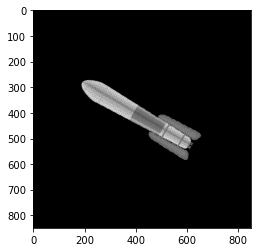

In [11]:
plt.imshow(rotatedImage,cmap='gray')

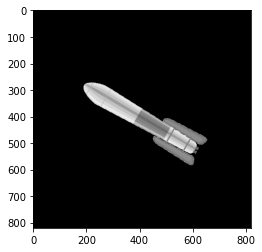

In [12]:
plt.imshow(cohete_des,cmap='gray')

# Problema 2

In [13]:
escalera_fija = cv2.imread('escalera_fija.jpeg',0)
escalera_des = cv2.imread('escalera_des.jpeg',0)

In [14]:
# homography matrix
aimg = alignRansac(escalera_fija,escalera_des)

[[-3.07088052e-03  1.00108695e+00  2.75546590e-01]
 [-1.00434932e+00  2.31626009e-03  4.98324887e+02]
 [-1.38397988e-05  9.43009334e-06  1.00000000e+00]]


In [15]:
# get keypoints by sift method
sift = cv2.xfeatures2d.SIFT_create(40)
kp_a = sift.detect(escalera_fija,None)
kp_b = sift.detect(escalera_des,None)
# arrange keypoint vectors
x_a = [[kp.pt[0]] for kp in kp_a]
y_a = [[kp.pt[1]] for kp in kp_a]
x_b = [[kp.pt[0]] for kp in kp_b]
y_b = [[kp.pt[1]] for kp in kp_b]
# create ransac regressor object
ransac = RANSACRegressor()
#fit model for first image
ransac.fit(x_a,y_a)
line_a = np.arange(min(x_a)[0],max(x_a)[0])[:,np.newaxis]
ransac_a = ransac.predict(line_a)

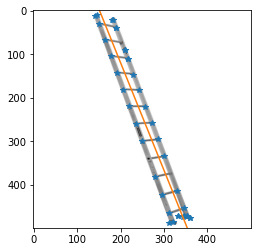

In [16]:
# plot model regression for first image
plt.plot(x_a,y_a,'*')
plt.plot(line_a,ransac_a)
plt.imshow(escalera_fija,cmap='gray')

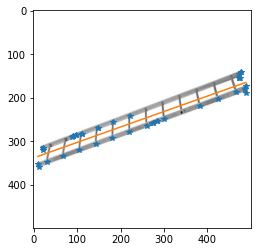

In [17]:
# fit model for second image
ransac.fit(x_b,y_b)
# get regression result for second image
line_b = np.arange(min(x_b)[0],max(x_b)[0])[:,np.newaxis]
ransac_b = ransac.predict(line_b)
# plot model regression for second image
plt.plot(x_b,y_b,'*')
plt.plot(line_b,ransac_b)
plt.imshow(escalera_des,cmap='gray')

In [18]:
# get rotation between two lines
m1 = (y_a[1][0]-y_a[0][0])/(x_a[1][0]-x_a[0][0])
m2 = (y_b[1][0]-y_b[0][0])/(x_b[1][0]-x_b[0][0])
# angles
theta_a = math.degrees(math.atan(m1))
theta_b = math.degrees(math.atan(m2))
thetaRot = theta_a-theta_b

In [64]:
rot = rotImage(escalera_fija,thetaRot)
print(thetaRot)

90.61214227524206


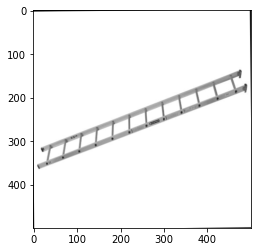

In [20]:
plt.imshow(rot,cmap="gray")

# Problema 3

In [79]:
dragon_fijo = o3d.io.read_point_cloud("dragon_fijo.ply")
dragon_des = o3d.io.read_point_cloud("dragon_des.ply")
# compute normals of the point cloud
#down = dragon_fijo.voxel_down_sample(voxel_size=0.005)
#dragon_fijo.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,max_nn=30))
#dragon_des.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,max_nn=30))

In [87]:
# show original cloud points
o3d.visualization.draw_geometries([dragon_fijo])

In [83]:
# set initial parameters
threshold = 0.2
trans_init = np.asarray([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0], [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(dragon_fijo, dragon_des, trans_init) #initial alignment
evaluation = o3d.pipelines.registration.evaluate_registration(dragon_fijo, dragon_des,
                                                    threshold, trans_init)
print(evaluation)

RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.325276e-03, and correspondence_set size of 100250
Access transformation to get result.


In [84]:
# Apply point-to-point ICP
reg_p2p = o3d.pipelines.registration.registration_icp(
    dragon_fijo, dragon_des, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
# homography transformation
print("Transformation is:")
print(reg_p2p.transformation)
# o3d.pipelines.registration.TransformationEstimationPointToPlane <- point-to-plane ICP

RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.080232e-09, and correspondence_set size of 100250
Access transformation to get result.
Transformation is:
[[ 9.78147603e-01 -2.07911680e-01 -5.29701035e-11 -7.50049093e-10]
 [ 2.07911680e-01  9.78147603e-01 -2.17642034e-09  2.42266666e-09]
 [ 5.04315763e-10  2.11784753e-09  1.00000000e+00 -2.27154423e-10]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [85]:
# show first registration
draw_registration_result(dragon_fijo, dragon_des, reg_p2p.transformation)

In [86]:
# transform original image
dragon_fijo.transform(reg_p2p.transformation)

PointCloud with 100250 points.

In [101]:
# compute Hausdorff similarity
pcd_a = np.asarray(dragon_fijo.points)
pcd_b = np.asarray(dragon_des.points)
hausdorff_distance = 0
maxLength = len(pcd_a) if len(pcd_a)>len(pcd_b) else len(pcd_b)
for i in range(maxLength):
    if i<len(pcd_a) and i<len(pcd_b):
        distance = max([pcd_a[i][0]-pcd_b[i][0],pcd_a[i][1]-pcd_b[i][1],pcd_a[i][2]-pcd_b[i][2]])
        hausdorff_distance = distance if distance>hausdorff_distance else hausdorff_distance
print(f'La distancia Hausdorff entre los dos conjuntos es {hausdorff_distance}')

La distancia Hausdorff entre los dos conjuntos es 2.1431777963432097e-08
